# Inference

This code compares and analyzes the results of adding several attention blocks to the __first layer__ of ResNet18 and VGG19.

The attention blocks used in the analysis are as follows.
 - Base model (without adding any attention blocks)
 - SE (residual) + SA
 - SE + SA
 - CBAM
 - Our model

In [1]:
import argparse
import cv2
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image

from resnet_cifar.resnet import *
from vgg_cifar import vgg

## Set hyperparameters

In [2]:
class ResNet_agrument:
    def __init__(self):
        self.arch = 'vgg19'
        self.workers = 4
        self.batch_size = 4  # Sample images for inferencing   
        self.cpu = False
        self.dataset = 'cifar100'        
        self.checkpoint = None
        self.block = ''

class VGG_agrument(ResNet_agrument):
    def __init__(self):
        super().__init__()
        self.arch = 'vgg19'
        self.dataset = 'cifar10'

In [3]:
# [model]_names : The name to be used in the output of the result
# [model]_block : Block type and its layer location ([Block type]_[Layer location to be added])
# [model]_checkpoints : Weight file of each model

resnet_names   = ['ResNet (base)', 'SE (residual) + SA', 'SE + SA', 'CBAM', 'Our model']
resnet_blocks  = ['RESNET', 'SE_SA_1', 'SEC_SA_1', 'CBAM_1', 'NEW_1']
resnet_checkpoints = ['weights/resnet18/cifar100/resnet_checkpoint_192.pth',
                      'weights/resnet18/cifar100/combine/ser_sa/SER_SA_1_checkpoint_199.pth',
                      'weights/resnet18/cifar100/combine/sec_sa/SEC_SA_1_checkpoint_191.pth',
                      'weights/resnet18/cifar100/combine/cbam/CBAM_1_checkpoint_189.pth',
                      'weights/resnet18/cifar100/combine/ours/Ours_1_checkpoint_192.pth']

vgg_names   = ['VGG19 (base)', 'SE (residual) + SA', 'SE + SA', 'CBAM', 'Our model']
vgg_blocks  = ['VGG19', 'SE_SA_1', 'SEC_SA_1', 'CBAM_1', 'NEW_1']
vgg_checkpoints = ['weights/vgg19/cifar10/vgg_checkpoint_299.tar',
                   'weights/vgg19/cifar10/combine/ser_sa/SER_SA_1_checkpoint_299.tar',
                   'weights/vgg19/cifar10/combine/sec_sa/SEC_SA_1_checkpoint_299.tar',
                   'weights/vgg19/cifar10/combine/cbam/CBAM_1_checkpoint_299.tar',
                   'weights/vgg19/cifar10/combine/ours/Ours_1_checkpoint_299.tar']

## Set the class names

In [4]:
# Label and its index for CIFAR10
# https://www.cs.toronto.edu/~kriz/cifar.html
class_cifar10 = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
                 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

# Label and its index for CIFAR100
# https://huggingface.co/datasets/cifar100
class_cifar100 = {0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3: 'bear', 4: 'beaver', 5: 'bed', 6: 'bee', 7: 'beetle',
                  8: 'bicycle', 9: 'bottle', 10: 'bowl', 11: 'boy', 12: 'bridge', 13: 'bus', 14: 'butterfly',
                  15: 'camel', 16: 'can', 17: 'castle', 18: 'caterpillar', 19: 'cattle', 20: 'chair', 21: 'chimpanzee',
                  22: 'clock', 23: 'cloud', 24: 'cockroach', 25: 'couch', 26: 'cra', 27: 'crocodile', 28: 'cup',
                  29: 'dinosaur', 30: 'dolphin', 31: 'elephant', 32: 'flatfish', 33: 'forest', 34: 'fox', 35: 'girl',
                  36: 'hamster', 37: 'house', 38: 'kangaroo', 39: 'keyboard', 40: 'lamp', 41: 'lawn_mower',
                  42: 'leopard', 43: 'lion', 44: 'lizard', 45: 'lobster', 46: 'man', 47: 'maple_tree', 48: 'motorcycle',
                  49: 'mountain', 50: 'mouse', 51: 'mushroom', 52: 'oak_tree', 53: 'orange', 54: 'orchid', 55: 'otter',
                  56: 'palm_tree', 57: 'pear', 58: 'pickup_truck', 59: 'pine_tree', 60: 'plain', 61: 'plate',
                  62: 'poppy', 63: 'porcupine', 64: 'possum', 65: 'rabbit', 66: 'raccoon', 67: 'ray', 68: 'road',
                  69: 'rocket', 70: 'rose', 71: 'sea', 72: 'seal', 73: 'shark', 74: 'shrew', 75: 'skunk',
                  76: 'skyscraper', 77: 'snail', 78: 'snake', 79: 'spider', 80: 'squirrel', 81: 'streetcar',
                  82: 'sunflower', 83: 'sweet_pepper', 84: 'table', 85: 'tank', 86: 'telephone', 87: 'television',
                  88: 'tiger', 89: 'tractor', 90: 'train', 91: 'trout', 92: 'tulip', 93: 'turtle', 94: 'wardrobe',
                  95: 'whale', 96: 'willow_tree', 97: 'wolf', 98: 'woman', 99: 'worm'}

# 1. ResNet18 Inference with CIFAR-100

Compare the ground truth and inference results, and check where the ResNet model paid attention when making inference with GradCam.

## 1.1 Implement functions

In [5]:
def resnet_inference(args, images, labels):
    print("dataset :", args.dataset)
    print("checkpoint :", args.checkpoint)
    
    if args.dataset == "cifar100":
        num_classes = 100
        classes = class_cifar100
    else:
        num_classes = 10
        classes = class_cifar10

    #############################################
    # Load model
    #############################################
    model = ResNet18(block=args.block, num_classes=num_classes)
    # print(model.layer4)

    cam_layers = [model.layer4]

    device = 'cuda' if torch.cuda.is_available() and not args.cpu else 'cpu'

    model = model.to(device)
    if device == 'cuda':
        model = torch.nn.DataParallel(model)

    checkpoint = torch.load(args.checkpoint)
    model.load_state_dict(checkpoint['net'])

    #############################################
    # Evaluate model
    #############################################    
    np_labels = labels.detach().cpu()    
    output = model(images)
    maxk = 1
    pred = output.topk(maxk, 1, True, True)
    np_indices = pred.indices.detach().cpu()
    print("\nResults")
    print(" - Ground truth : " + str([classes[int(np_labels[j])] for j in range(args.batch_size)]))    
    print(" - Inference    : " + str([classes[int(np_indices[j][0])] for j in range(args.batch_size)]))
    correct_answers = sum(1 if int(np_labels[j]) == int(np_indices[j][0]) else 0 for j in range(args.batch_size))
    print(" - Accuracy     : %3.1f%%" % (correct_answers/args.batch_size*100))

    #############################################
    # Create CAM
    #############################################
    cam = GradCAM(model=model, target_layers=cam_layers, use_cuda=False if device == 'cpu' else True)
    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=False if device == 'cpu' else True)

    grayscale_cams = cam(input_tensor=images)

    final_cam = None
    for idx, grayscale_cam in enumerate(grayscale_cams):
        tensor_img = images[idx]

        rgb_img = deprocess_image(tensor_img.permute(1, 2, 0).numpy()) / 255.0
        # print(rgb_img)
        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
        cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

        if final_cam is None:
            final_cam = cam_image
        else:
            final_cam = cv2.hconcat([final_cam, cam_image])
        
    fig = plt.figure()
    plt.imshow(final_cam)
    plt.title("GradCam Images")    
    plt.show()

## 1.2 Analyze inference results

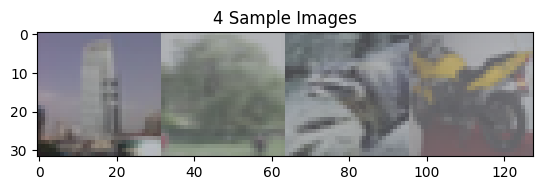


########################################################################################
Inference of "ResNet (base)"
dataset : cifar100
checkpoint : weights/resnet18/cifar100/resnet_checkpoint_192.pth

Results
 - Ground truth : ['skyscraper', 'willow_tree', 'raccoon', 'motorcycle']
 - Inference    : ['skyscraper', 'willow_tree', 'otter', 'motorcycle']
 - Accuracy     : 75.0%


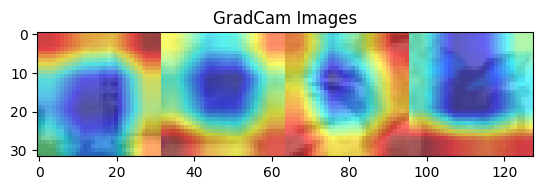

########################################################################################

########################################################################################
Inference of "SE (residual) + SA"
dataset : cifar100
checkpoint : weights/resnet18/cifar100/combine/ser_sa/SER_SA_1_checkpoint_199.pth

Results
 - Ground truth : ['skyscraper', 'willow_tree', 'raccoon', 'motorcycle']
 - Inference    : ['skyscraper', 'willow_tree', 'raccoon', 'motorcycle']
 - Accuracy     : 100.0%


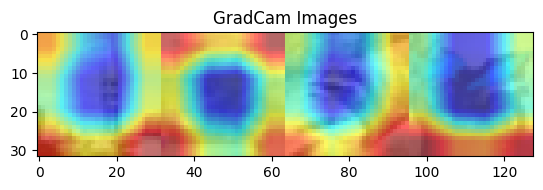

########################################################################################

########################################################################################
Inference of "SE + SA"
dataset : cifar100
checkpoint : weights/resnet18/cifar100/combine/sec_sa/SEC_SA_1_checkpoint_191.pth

Results
 - Ground truth : ['skyscraper', 'willow_tree', 'raccoon', 'motorcycle']
 - Inference    : ['skyscraper', 'willow_tree', 'otter', 'motorcycle']
 - Accuracy     : 75.0%


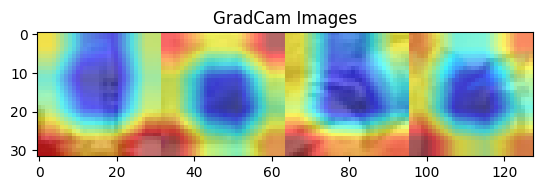

########################################################################################

########################################################################################
Inference of "CBAM"
dataset : cifar100
checkpoint : weights/resnet18/cifar100/combine/cbam/CBAM_1_checkpoint_189.pth

Results
 - Ground truth : ['skyscraper', 'willow_tree', 'raccoon', 'motorcycle']
 - Inference    : ['skyscraper', 'willow_tree', 'crocodile', 'motorcycle']
 - Accuracy     : 75.0%


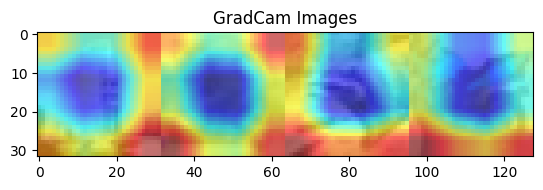

########################################################################################

########################################################################################
Inference of "Our model"
dataset : cifar100
checkpoint : weights/resnet18/cifar100/combine/ours/Ours_1_checkpoint_192.pth

Results
 - Ground truth : ['skyscraper', 'willow_tree', 'raccoon', 'motorcycle']
 - Inference    : ['skyscraper', 'willow_tree', 'otter', 'motorcycle']
 - Accuracy     : 75.0%


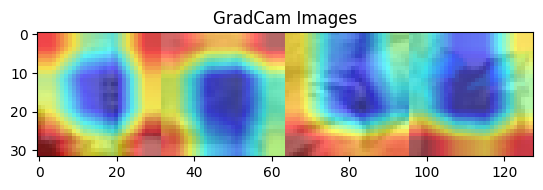

########################################################################################


In [9]:
args = ResNet_agrument()

###########################################################
# Load dataset
###########################################################
normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
if args.dataset == "cifar100":
    val_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR100(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)
else:
    val_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)
    
dataiter = iter(val_loader)
images, labels = next(dataiter)

###########################################################
# Display sample images
###########################################################
original_img = None
for tensor_img in images:
    rgb_img = deprocess_image(tensor_img.permute(1, 2, 0).numpy()) / 255.0

    if original_img is None:
        original_img = rgb_img
    else:
        original_img = cv2.hconcat([original_img, rgb_img])

fig = plt.figure()
plt.imshow(original_img)
plt.title("%d Sample Images" % args.batch_size)
plt.show()

###########################################################
# Run inference of each model with same sample images
###########################################################
for bt, bn, bw in zip(resnet_blocks, resnet_names, resnet_checkpoints):
    print()
    print('########################################################################################')
    print('Inference of "%s"' %bn)
    args.block = bt
    args.checkpoint = bw
    resnet_inference(args, images, labels)
    print('########################################################################################')

# 2 VGG19 Inference with CIFAR-10

Compare the ground truth and inference results

## 2.1 Implement functions

In [7]:
def vgg_inference(args, images, labels):
    print("dataset :", args.dataset)
    print("checkpoint :", args.checkpoint)
    
    if args.dataset == "cifar100":
        num_classes = 100
        classes = class_cifar100
    else:
        num_classes = 10
        classes = class_cifar10

    #############################################
    # Load model
    #############################################
    model = vgg.__dict__[args.arch](num_classes, args.block)

    model.features = torch.nn.DataParallel(model.features)
    if args.cpu:
        model.cpu()
    else:
        model.cuda()
    checkpoint = torch.load(args.checkpoint)
    model.load_state_dict(checkpoint['state_dict'])

    #############################################
    # Evaluate model
    #############################################    
    np_labels = labels.detach().cpu()
    output = model(images)
    maxk = 1
    pred = output.topk(maxk, 1, True, True)
    np_indices = pred.indices.detach().cpu()   
    print("\nResults")
    print(" - Ground truth : " + str([classes[int(np_labels[j])] for j in range(args.batch_size)]))    
    print(" - Inference    : " + str([classes[int(np_indices[j][0])] for j in range(args.batch_size)]))
    correct_answers = sum(1 if int(np_labels[j]) == int(np_indices[j][0]) else 0 for j in range(args.batch_size))
    print(" - Accuracy     : %3.1f%%" % (correct_answers/args.batch_size*100))

## 2.2 Analyze inference results

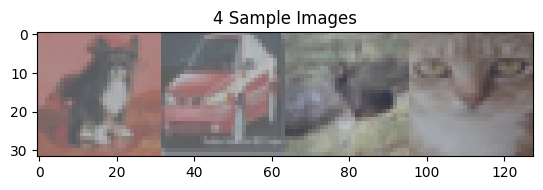


########################################################################################
Inference of "VGG19 (base)"
dataset : cifar10
checkpoint : weights/vgg19/cifar10/vgg_checkpoint_299.tar

Results
 - Ground truth : ['dog', 'automobile', 'deer', 'cat']
 - Inference    : ['dog', 'automobile', 'deer', 'cat']
 - Accuracy     : 100.0%
########################################################################################

########################################################################################
Inference of "SE (residual) + SA"
dataset : cifar10
checkpoint : weights/vgg19/cifar10/combine/ser_sa/SER_SA_1_checkpoint_299.tar

Results
 - Ground truth : ['dog', 'automobile', 'deer', 'cat']
 - Inference    : ['dog', 'automobile', 'deer', 'cat']
 - Accuracy     : 100.0%
########################################################################################

########################################################################################
Inference of "SE + SA"
dataset

In [8]:
args = VGG_agrument()

#############################################
# Load dataset
#############################################
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
if args.dataset == "cifar100":
    val_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR100(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)
else:
    val_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)

dataiter = iter(val_loader)
images, labels = next(dataiter)        

###########################################################
# Display sample images
###########################################################
original_img = None
for tensor_img in images:
    rgb_img = deprocess_image(tensor_img.permute(1, 2, 0).numpy()) / 255.0

    if original_img is None:
        original_img = rgb_img
    else:
        original_img = cv2.hconcat([original_img, rgb_img])

fig = plt.figure()
plt.imshow(original_img)
plt.title("%d Sample Images" % args.batch_size)
plt.show()

###########################################################
# Run inference of each model with same sample images
###########################################################
for bt, bn, bw in zip(vgg_blocks, vgg_names, vgg_checkpoints):
    print()
    print('########################################################################################')
    print('Inference of "%s"' %bn)
    args.block = bt
    args.checkpoint = bw
    vgg_inference(args, images, labels)
    print('########################################################################################')